# Problem Description

Costelloe Fishery wants to understand if they should build a new dam. They want to understand if rainfall will increase or decrease in the future, and have some certainty about this. If it increases, they'll need a new dam. If it decreases, they can keep the dam they currently have.

The Irish Government has provided data in the form of a .csv file with daily rainfall from 1960 until 2024. Can we say if rainfall will increase in the future? How much certainty will we have?

## Loading and Cleaning Data

Loading is straightforward (well, sometimes), it's just getting the data into somewhere it can be manipulated. It's easiest to get it into Pandas, typically. If the dataset is too big to get into Pandas, then, well, cut it down to size. You can't know what to do with it until you understand it! Sometimes (as in this case) it means a bit of manipulation of the data, such as forcing dates to be dates, removing or filling in null values, etc.

In [1]:
# Clean the data (Remove superflous information)

with open("./costelloe_fishery.csv", "r", encoding="utf-8") as f:
    csv_data = [line for line in f.readlines() if line.count(",") >= 2]

with open("./costello_fishery_clean.csv", "w", encoding="utf-8") as f:
    f.write("".join(csv_data))

In [2]:
# Load the data
import pandas as pd
 
df = pd.read_csv("./costello_fishery_clean.csv")
df.head()

,date,ind,rain
0,01-oct-1960,8,17.8
1,02-oct-1960,8,3.0
2,03-oct-1960,8,0.2
3,04-oct-1960,8,0.2
4,05-oct-1960,8,2.1


In [3]:
# Clean the data (ensure dates are real)
## resource used: https://saturncloud.io/blog/converting-a-column-to-date-format-in-pandas-dataframe/

df = df.fillna(0)
df["date"] = pd.to_datetime(df["date"])
df["ind"] = pd.to_numeric(df["ind"])
df["rain"] = pd.to_numeric(df["rain"])
df = df.rename(columns={"rain": "rain_mm"})
df.head()

/tmp/ipykernel_271552/1080621281.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"])


,date,ind,rain_mm
0,1960-10-01,8,17.8
1,1960-10-02,8,3.0
2,1960-10-03,8,0.2
3,1960-10-04,8,0.2
4,1960-10-05,8,2.1


## Exploratory Data Analysis (EDA)

This is what it says on the tin - playing around with the data until it is understood. That can mean visualising, using summary statistics, etc. to better get a grip on the kind of data we're looking at.

In [4]:
# Exploratory Data Analysis

# this shows how many rows there are, and how many columns
df.shape

(23285, 3)

In [29]:
## Summary Stats
from scipy.stats import describe

result = describe(df["rain_mm"])
print("Minimum", result.minmax[0], "Maximum", result.minmax[1])
print("Mean", round(result.mean, 2))
print("Variance", round(result.variance, 2))

Minimum 0.0 Maximum 98.0
Mean 3.57
Variance 32.04


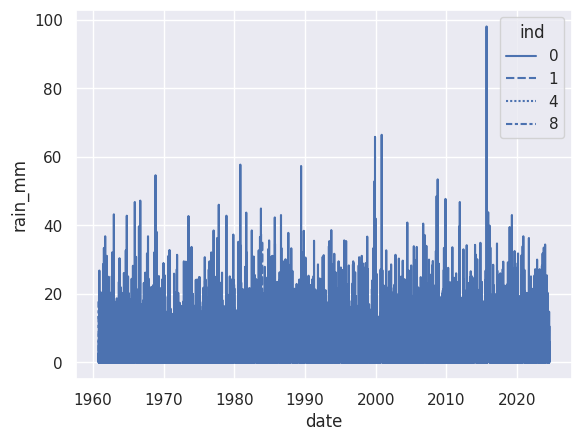

In [ ]:
## Visualisation (time series)
# resources used:
# https://www.datacamp.com/tutorial/python-seaborn-line-plot-tutorial
import seaborn as sns

sns.set_theme()

sns.lineplot(data=df, x="date", y="rain_mm", style="ind");

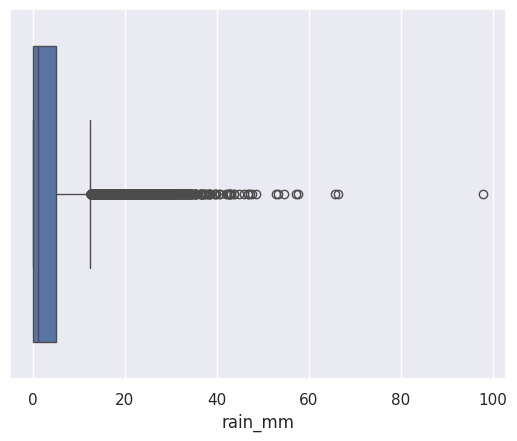

In [20]:
sns.boxplot(data=df, x="rain_mm");

## Feature Engineering

We may find that we don't have all the information, or the information we have may not be to our liking. This is where we get into feature engineering: editing the data, basically, to make it more usable for our purposes. In this case, we'll do a bit of lightweight feature engineering where we'll sum up the monthly totals of rainfall (which would be useful in seeing how big of a dam we'd need to build).

In [ ]:
# resources used:
# https://www.statology.org/pandas-group-by-month/
# https://stackoverflow.com/questions/24980437/pandas-groupby-and-then-merge-on-original-table

df["date_month"] = df["date"]
df["date_year"] = df["date"]
month_series = df.groupby([df["date_year"].dt.year, df["date_month"].dt.month])["rain_mm"].sum()
month_df = pd.DataFrame(month_series)
month_df = month_df.reset_index()
month_df.head()

,date_year,date_month,rain_mm
0,1960,10,78.0
1,1960,11,209.4
2,1960,12,158.7
3,1961,1,201.4
4,1961,2,121.2


In [15]:
month_df.shape

(765, 3)

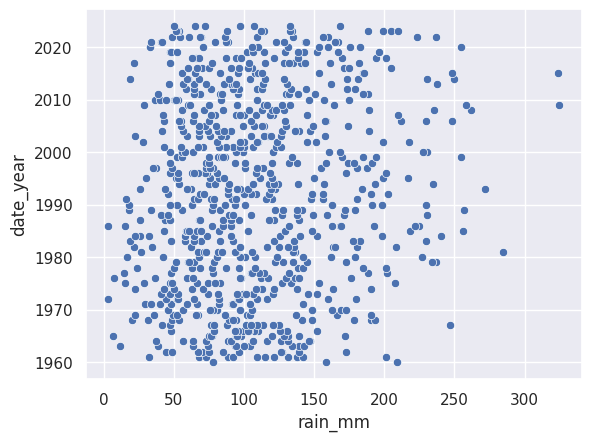

In [23]:
sns.scatterplot(data=month_df, x="rain_mm", y="date_year");

## Training / Fitting

Usually the data is split into training and test datasets. The training data is used to (you guessed it) teach the computer, the test data is left out to find out how well the computer was taught. If we include all the data to train, we may not know how it does on 'unforseen' data (it may overfit).

We can try that here: take training and evaluation datasets from the data, and use linear regression to train it, and see (based on the evaluation) if it generally fits the history. This will help inform if we're making a general conclusion about rainfall or if we've overfit to the data.

In [ ]:
# Use Linear Regression
## Resources
# https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

X = month_df[["date_year"]]
y = month_df[["rain_mm"]]
reg = LinearRegression().fit(X=X, y=y)

round(reg.score(X, y), 3)

0.013

In [12]:
# Use BigQuery